## Install packages

In [21]:
#%pip install -U pandas numpy scikit-learn scipy matplotlib tqdm nltk
#%pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#%pip install optuna optuna-dashboard

## Imports + config + device

In [22]:
import os, re, random, time
from dataclasses import dataclass
from collections import Counter

import numpy as np
import pandas as pd

import optuna

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, f1_score, average_precision_score, log_loss

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler


print("Torch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

Torch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 2050


## Reproducibility + global settings

In [23]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

@dataclass
class CFG:
    seed: int = 42
    data_path: str = "./data/jigsaw/train.csv"
    subsample_n: int | None = 200_000  # set None to use full file (big)
    test_size: float = 0.1
    val_size: float = 0.1  # fraction of remaining train for validation
    label_threshold: float = 0.5

    # TF-IDF
    max_features: int = 50_000
    ngram_range: tuple = (1, 2)
    min_df: int = 2

    # PyTorch training
    batch_size: int = 256
    epochs: int = 3
    lr: float = 1e-3
    weight_decay: float = 1e-4
    optimizer: str = "adam"  # "adam" or "sgd"
    momentum: float = 0.9
    grad_clip_norm: float | None = 1.0

    # Sequence model
    seq_max_len: int = 200
    vocab_size: int = 50_000
    emb_dim: int = 128
    lstm_hidden: int = 128
    lstm_layers: int = 1
    dropout: float = 0.3

cfg = CFG()
seed_everything(cfg.seed)
cfg


CFG(seed=42, data_path='./data/jigsaw/train.csv', subsample_n=200000, test_size=0.1, val_size=0.1, label_threshold=0.5, max_features=50000, ngram_range=(1, 2), min_df=2, batch_size=256, epochs=3, lr=0.001, weight_decay=0.0001, optimizer='adam', momentum=0.9, grad_clip_norm=1.0, seq_max_len=200, vocab_size=50000, emb_dim=128, lstm_hidden=128, lstm_layers=1, dropout=0.3)

## Load Jigsaw train.csv + label + subsample

In [24]:
df = pd.read_csv(cfg.data_path)
print(df.shape)
df = df.dropna(subset=["comment_text", "target"]).reset_index(drop=True)

df["label"] = (df["target"] >= cfg.label_threshold).astype(int)

# Optional: subsample (keep label distribution)
if cfg.subsample_n is not None and len(df) > cfg.subsample_n:
    df, _ = train_test_split(
        df,
        train_size=cfg.subsample_n,
        stratify=df["label"],
        random_state=cfg.seed
    )
    df = df.reset_index(drop=True)

df[["target", "label"]].describe()

# Class frequency (counts and ratios)
class_counts = df["label"].value_counts().sort_index()
class_ratios = (class_counts / class_counts.sum()).round(4)
print("Class counts:\n", class_counts)
print("Class ratios:\n", class_ratios)

(1804874, 45)
Class counts:
 label
0    184006
1     15994
Name: count, dtype: int64
Class ratios:
 label
0    0.92
1    0.08
Name: count, dtype: float64


## Train/Val/Test split

In [25]:
X = df["comment_text"].astype(str).values
y = df["label"].values

# First: split out test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=cfg.test_size,
    stratify=y,
    random_state=cfg.seed
)

# Then: split train/val from remaining
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=cfg.val_size,
    stratify=y_trainval,
    random_state=cfg.seed
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))
print("Pos rate train/val/test:", y_train.mean(), y_val.mean(), y_test.mean())

def show_split_stats(name, y):
    counts = pd.Series(y).value_counts().sort_index()
    ratios = (counts / counts.sum()).round(4)
    print(f"{name} counts:\n{counts}")
    print(f"{name} ratios:\n{ratios}")

show_split_stats("Train", y_train)
show_split_stats("Val", y_val)
show_split_stats("Test", y_test)
train_class_counts = np.bincount(y_train)
train_class_weights = 1.0 / train_class_counts
train_sample_weights = train_class_weights[y_train]



Train: 162000 Val: 18000 Test: 20000
Pos rate train/val/test: 0.07997530864197532 0.07994444444444444 0.07995
Train counts:
0    149044
1     12956
Name: count, dtype: int64
Train ratios:
0    0.92
1    0.08
Name: count, dtype: float64
Val counts:
0    16561
1     1439
Name: count, dtype: int64
Val ratios:
0    0.9201
1    0.0799
Name: count, dtype: float64
Test counts:
0    18401
1     1599
Name: count, dtype: int64
Test ratios:
0    0.9200
1    0.0799
Name: count, dtype: float64


## Preprocessing: tokenization + stemming + lemmatization

In [26]:
# NLTK downloads (run once)
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

_url_re = re.compile(r"https?://\S+|www\.\S+")
_html_re = re.compile(r"<.*?>")
_user_re = re.compile(r"@\w+")
_non_ascii_re = re.compile(r"[^\x00-\x7F]+")

_token_re = re.compile(r"[A-Za-z']+")

CLEAN_TEXT = True
REMOVE_STOPWORDS = True

def clean_text(text: str) -> str:
    text = text.lower()
    text = _url_re.sub(" ", text)
    text = _html_re.sub(" ", text)
    text = _user_re.sub(" ", text)
    text = _non_ascii_re.sub(" ", text)
    return text

def basic_tokenize(text: str):
    if CLEAN_TEXT:
        text = clean_text(text)
    else:
        text = text.lower()
    toks = _token_re.findall(text)
    if REMOVE_STOPWORDS:
        toks = [t for t in toks if t not in stop_words]
    return toks

def stem_text(text: str) -> str:
    toks = basic_tokenize(text)
    toks = [stemmer.stem(t) for t in toks]
    return " ".join(toks)

def lemma_text(text: str) -> str:
    toks = basic_tokenize(text)
    toks = [lemmatizer.lemmatize(t) for t in toks]
    return " ".join(toks)

# Choose one:
PREPROC_MODE = "raw"  # "raw" | "stem" | "lemma"

def preprocess_array(arr):
    if PREPROC_MODE == "raw":
        if CLEAN_TEXT or REMOVE_STOPWORDS:
            return np.array([" ".join(basic_tokenize(x)) for x in tqdm(arr, desc=f"preprocess={PREPROC_MODE}")], dtype=object)
        return arr
    fn = stem_text if PREPROC_MODE == "stem" else lemma_text
    return np.array([fn(x) for x in tqdm(arr, desc=f"preprocess={PREPROC_MODE}")], dtype=object)
X_train_p = preprocess_array(X_train)
X_val_p   = preprocess_array(X_val)
X_test_p  = preprocess_array(X_test)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stjepan.vinski\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\stjepan.vinski\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stjepan.vinski\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
preprocess=raw: 100%|██████████| 20000/20000 [00:00<00:00, 64494.17it/s]


## Common evaluation helper

In [27]:
def eval_binary(y_true, y_pred, name="model", show_report=False):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    print(f"{name}: acc={acc:.4f} precision={p:.4f} recall={r:.4f} f1={f1:.4f}")
    if show_report:
        print("Confusion matrix:")
        print(confusion_matrix(y_true, y_pred))
        print("Classification report:")
        print(classification_report(y_true, y_pred, digits=4, zero_division=0))
    return {"acc": acc, "precision": p, "recall": r, "f1": f1}

def find_best_threshold(y_true, y_prob, min_t=0.05, max_t=0.95, steps=19):
    thresholds = np.linspace(min_t, max_t, steps)
    best_t = 0.5
    best_f1 = -1.0
    for t in thresholds:
        f1 = f1_score(y_true, (y_prob >= t).astype(int))
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1
def eval_with_threshold(name, y_val, p_val, y_test, p_test, show_report=False):
    best_t, best_f1 = find_best_threshold(y_val, p_val)
    print(f"{name} best threshold (val) = {best_t:.2f}, f1={best_f1:.4f}")

    val_pred = (p_val >= best_t).astype(int)
    test_pred = (p_test >= best_t).astype(int)

    metrics_val = eval_binary(y_val, val_pred, f"{name} (val @t={best_t:.2f})")
    metrics_test = eval_binary(y_test, test_pred, f"{name} (test @t={best_t:.2f})", show_report=show_report)
    return best_t, metrics_val, metrics_test



In [28]:
# BOW visualization: top unigrams + bigrams/trigrams, overall and by class (train only)
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(texts, ngram_range=(1, 1), top_k=20):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=2, max_features=50_000)
    X = vec.fit_transform(texts)
    counts = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    top_idx = counts.argsort()[::-1][:top_k]
    return pd.DataFrame({"term": vocab[top_idx], "count": counts[top_idx]})

# Overall most frequent words
top_words = top_ngrams(X_train_p, ngram_range=(1, 1), top_k=20)
print("Top words (overall):")
print(top_words)

# Most frequent bigrams and trigrams
top_bigrams = top_ngrams(X_train_p, ngram_range=(2, 2), top_k=20)
print("Top bigrams (overall):")
print(top_bigrams)

top_trigrams = top_ngrams(X_train_p, ngram_range=(3, 3), top_k=20)
print("Top trigrams (overall):")
print(top_trigrams)

# Most frequent words by class
X_train_p_0 = X_train_p[y_train == 0]
X_train_p_1 = X_train_p[y_train == 1]

top_words_0 = top_ngrams(X_train_p_0, ngram_range=(1, 1), top_k=20)
top_words_1 = top_ngrams(X_train_p_1, ngram_range=(1, 1), top_k=20)

print("Top words (class 0 - non-harmful):")
print(top_words_0)

print("Top words (class 1 - harmful):")
print(top_words_1)


Top words (overall):
      term  count
0   people  27628
1    would  27478
2      one  24224
3     like  23103
4    trump  21687
5      get  17733
6       us  15449
7     time  14334
8    think  13353
9     know  12547
10    many  12485
11    even  12283
12   right  12245
13    good  12169
14     see  11020
15   years  10978
16    make  10806
17    much  10717
18    well  10572
19     way  10369
Top bigrams (overall):
                  term  count
0            years ago   1575
1          health care   1490
2         donald trump   1188
3        united states   1135
4            fake news   1040
5          many people    989
6          sounds like    968
7       climate change    939
8      president trump    841
9          white house    797
10          income tax    781
11          looks like    767
12          would like    765
13         people like    719
14         even though    710
15            year old    701
16       supreme court    699
17          right wing    689
18      

len_test: 100%|██████████| 20000/20000 [00:00<00:00, 106457.25it/s]


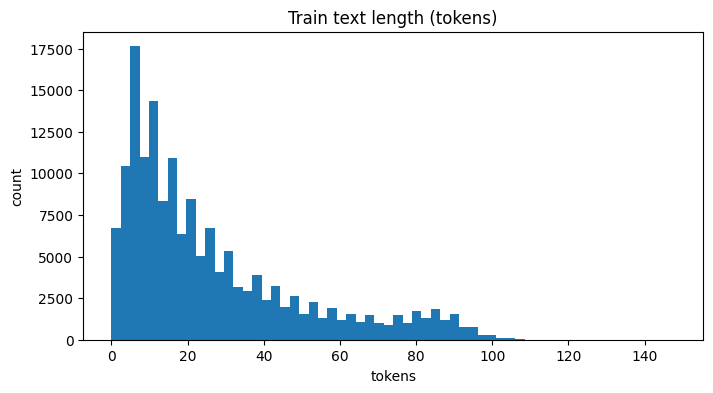

Length quantiles (train): {0.5: 18, 0.75: 37, 0.9: 66, 0.95: 82, 0.98: 90, 0.99: 93}
Cutoff: remove all samples with length > 82 tokens (q=0.95)
Train: kept=154426, removed=7574, removed%=4.68%
Train: min=0, max=148, mean=26.38
Val: kept=17117, removed=883, removed%=4.91%
Val: min=0, max=113, mean=26.30
Test: kept=19029, removed=971, removed%=4.86%
Test: min=0, max=148, mean=26.50
Top 3 longest train samples (lengths): [148 126 126]
After filtering: 154426 17117 19029
Pos rate train/val/test: 0.08102910131713571 0.08079686861015364 0.08045614588260024


In [29]:
# Text length analysis + windowing (train-driven)
def get_lengths(texts, desc):
    return np.array([len(basic_tokenize(t)) for t in tqdm(texts, desc=desc)], dtype=int)

train_lens = get_lengths(X_train_p, "len_train")
val_lens   = get_lengths(X_val_p, "len_val")
test_lens  = get_lengths(X_test_p, "len_test")

# Histogram (train only)
plt.figure(figsize=(8,4))
plt.hist(train_lens, bins=60)
plt.title("Train text length (tokens)")
plt.xlabel("tokens")
plt.ylabel("count")
plt.show()

# Quantiles + removal summary (train-driven)
qs = [0.5, 0.75, 0.9, 0.95, 0.98, 0.99]
q_vals = {q: int(np.quantile(train_lens, q)) for q in qs}
print("Length quantiles (train):", q_vals)

q = 0.95  # choose cutoff here
max_len = q_vals[q]
print(f"Cutoff: remove all samples with length > {max_len} tokens (q={q})")

def removal_stats(lens, max_len, name):
    removed = (lens > max_len).sum()
    kept = (lens <= max_len).sum()
    print(f"{name}: kept={kept}, removed={removed}, removed%={(removed/len(lens))*100:.2f}%")
    print(f"{name}: min={lens.min()}, max={lens.max()}, mean={lens.mean():.2f}")

removal_stats(train_lens, max_len, "Train")
removal_stats(val_lens,   max_len, "Val")
removal_stats(test_lens,  max_len, "Test")

# Optional: show a few longest samples being removed (train)
idx_sorted = np.argsort(train_lens)[::-1]
print("Top 3 longest train samples (lengths):", train_lens[idx_sorted[:3]])

# Filter splits
def filter_by_len(X, y, lens, max_len):
    mask = lens <= max_len
    return X[mask], y[mask], lens[mask]

X_train_p, y_train, train_lens = filter_by_len(X_train_p, y_train, train_lens, max_len)
X_val_p, y_val, val_lens       = filter_by_len(X_val_p, y_val, val_lens, max_len)
X_test_p, y_test, test_lens    = filter_by_len(X_test_p, y_test, test_lens, max_len)

print("After filtering:", len(X_train_p), len(X_val_p), len(X_test_p))
print("Pos rate train/val/test:", y_train.mean(), y_val.mean(), y_test.mean())

# Update sequence padding length
cfg.seq_max_len = min(cfg.seq_max_len, max_len)

# Recompute sampler weights (y_train changed)
train_class_counts = np.bincount(y_train)
train_class_weights = 1.0 / train_class_counts
train_sample_weights = train_class_weights[y_train]


## Lexical Analysis

An analysis of the most frequent unigrams, bigrams, and trigrams in the training data shows that the dataset is dominated by conversational and opinion-oriented language. Common words such as *people*, *would*, *like*, and *think* indicate informal discussion, while frequent political references (e.g., *trump*, *united states*, *white house*) suggest that political discourse is a central theme.

Class-specific analysis reveals a clear lexical distinction between non-harmful and harmful comments. Non-harmful comments primarily contain neutral or descriptive language, whereas harmful comments include explicit offensive terms (e.g., *stupid*) and more emotionally charged expressions. 

These findings indicate that toxicity in the dataset is often expressed through short, explicit lexical cues rather than long-range contextual dependencies. This explains the strong performance of bag-of-words and TF-IDF based linear models, as they effectively capture the key discriminative signals present in the data.

## Hyperparameter Optimization (Optuna)

### Optuna: TF-IDF + LogReg


In [30]:
best_tfidf_params = {
    "max_features": cfg.max_features,
    "ngram_range": cfg.ngram_range,
    "min_df": cfg.min_df,
}
best_logreg_params = {
    "C": 1.0,
    "max_iter": 300,
}

N_TRIALS_TFIDF = 20

def objective_tfidf_logreg(trial):
    max_features = trial.suggest_int("max_features", 20000, 80000, step=10000)
    ngram_key = trial.suggest_categorical("ngram_range", ["1_1", "1_2"])
    ngram_range = (1, 1) if ngram_key == "1_1" else (1, 2)
    min_df = trial.suggest_int("min_df", 1, 5)
    C = trial.suggest_float("C", 0.1, 5.0, log=True)

    tfidf_opt = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=min_df
    )
    Xtr = tfidf_opt.fit_transform(X_train_p)
    Xva = tfidf_opt.transform(X_val_p)

    model = LogisticRegression(
        max_iter=300,
        n_jobs=-1,
        class_weight="balanced",
        C=C
    )
    model.fit(Xtr, y_train)

    val_prob = model.predict_proba(Xva)[:, 1]
    return log_loss(y_val, val_prob, labels=[0, 1])

optuna_db_path_tfidf = os.path.abspath("optuna_tfidf_logreg.db")
study_tfidf = optuna.create_study(
    direction="minimize",
    storage=f"sqlite:///{optuna_db_path_tfidf}",
    study_name="tfidf_logreg_v2",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=cfg.seed)
)

study_tfidf.optimize(objective_tfidf_logreg, n_trials=N_TRIALS_TFIDF)

best_ngram_val = study_tfidf.best_params["ngram_range"]
if isinstance(best_ngram_val, str):
    best_ngram = (1, 1) if best_ngram_val == "1_1" else (1, 2)
elif isinstance(best_ngram_val, list):
    best_ngram = tuple(best_ngram_val)
else:
    best_ngram = best_ngram_val

best_tfidf_params = {
    "max_features": study_tfidf.best_params["max_features"],
    "ngram_range": best_ngram,
    "min_df": study_tfidf.best_params["min_df"],
}
best_logreg_params = {
    "C": study_tfidf.best_params["C"],
    "max_iter": 300,
}

print("TF-IDF params:", best_tfidf_params)
print("LogReg params:", best_logreg_params)
print("Optuna DB:", optuna_db_path_tfidf)


[I 2026-01-17 17:30:53,663] A new study created in RDB with name: tfidf_logreg_v2
c:\Users\stjepan.vinski\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
[I 2026-01-17 17:30:56,554] Trial 0 finished with value: 0.37181733915582554 and parameters: {'max_features': 40000, 'ngram_range': '1_1', 'min_df': 3, 'C': 0.18410729205738682}. Best is trial 0 with value: 0.37181733915582554.
c:\Users\stjepan.vinski\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
[I 2026-01-17 17:31:08,615] Trial 1 finished with value: 0.277649651701102 and parameters: {

TF-IDF params: {'max_features': 60000, 'ngram_range': (1, 1), 'min_df': 5}
LogReg params: {'C': 4.370990468130501, 'max_iter': 300}
Optuna DB: c:\Stjepan\Fax\NepredniML\Projekt\optuna_tfidf_logreg.db


## Bag‑of‑Words + LogReg (baseline)

In [31]:
bow = CountVectorizer(
    max_features=cfg.max_features,
    ngram_range=cfg.ngram_range,
    min_df=cfg.min_df
)

Xtr_bow = bow.fit_transform(X_train_p)
Xva_bow = bow.transform(X_val_p)
Xte_bow = bow.transform(X_test_p)

logreg_bow = LogisticRegression(
    max_iter=200,
    n_jobs=-1,
    class_weight="balanced"
)

logreg_bow.fit(Xtr_bow, y_train)

val_prob = logreg_bow.predict_proba(Xva_bow)[:, 1]
test_prob = logreg_bow.predict_proba(Xte_bow)[:, 1]

bow_t, metrics_bow_val, metrics_bow_test = eval_with_threshold(
    "BOW+LogReg", y_val, val_prob, y_test, test_prob
)


c:\Users\stjepan.vinski\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


BOW+LogReg best threshold (val) = 0.60, f1=0.5791
BOW+LogReg (val @t=0.60): acc=0.9268 precision=0.5408 recall=0.6233 f1=0.5791
BOW+LogReg (test @t=0.60): acc=0.9277 precision=0.5419 recall=0.6545 f1=0.5929


## TF-IDF + Logistic Regression (baseline)

### Vectorize TF-IDF

In [32]:
tfidf = TfidfVectorizer(
    max_features=best_tfidf_params["max_features"],
    ngram_range=best_tfidf_params["ngram_range"],
    min_df=best_tfidf_params["min_df"]
)

Xtr_tfidf = tfidf.fit_transform(X_train_p)
Xva_tfidf = tfidf.transform(X_val_p)
Xte_tfidf = tfidf.transform(X_test_p)

Xtr_tfidf.shape, Xva_tfidf.shape


((154426, 28272), (17117, 28272))

### Logistic Regression baseline

In [33]:
logreg = LogisticRegression(
    max_iter=best_logreg_params["max_iter"],
    n_jobs=-1,
    class_weight="balanced",  # useful for skew
    C=best_logreg_params["C"]
)

logreg.fit(Xtr_tfidf, y_train)

val_prob = logreg.predict_proba(Xva_tfidf)[:, 1]
test_prob = logreg.predict_proba(Xte_tfidf)[:, 1]

tfidf_t, metrics_logreg_val, metrics_logreg_test = eval_with_threshold(
    "TFIDF+LogReg", y_val, val_prob, y_test, test_prob
)


c:\Users\stjepan.vinski\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


TFIDF+LogReg best threshold (val) = 0.80, f1=0.5892
TFIDF+LogReg (val @t=0.80): acc=0.9380 precision=0.6342 recall=0.5503 f1=0.5892
TFIDF+LogReg (test @t=0.80): acc=0.9404 precision=0.6422 recall=0.5839 f1=0.6117


## TF-IDF + MLP

### Sparse TF-IDF

In [34]:
class SparseTfidfDataset(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr.tocsr()
        self.y = y.astype(np.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        row = self.X[idx]
        x = torch.from_numpy(row.toarray().ravel()).float()
        y = torch.tensor(self.y[idx]).float()
        return x, y

train_ds = SparseTfidfDataset(Xtr_tfidf, y_train)
val_ds   = SparseTfidfDataset(Xva_tfidf, y_val)
test_ds  = SparseTfidfDataset(Xte_tfidf, y_test)

sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, sampler=sampler)
val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False)

Xtr_tfidf.shape


(154426, 28272)

### MLP model

In [35]:
class TfidfMLP(nn.Module):
    def __init__(self, in_dim, hidden=256, dropout=0.3, activation="relu"):
        super().__init__()
        self.activation = activation.lower()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, 1)

        # weight init
        if self.activation == "relu":
            nn.init.kaiming_normal_(self.fc1.weight)
        else:
            nn.init.xavier_normal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        if self.activation == "relu":
            x = F.relu(x)
        elif self.activation == "tanh":
            x = torch.tanh(x)
        elif self.activation == "sigmoid":
            x = torch.sigmoid(x)
        else:
            raise ValueError("activation must be relu/tanh/sigmoid")

        x = self.drop(x)
        return self.fc2(x).squeeze(1)  # logits


### Optuna: TF-IDF + MLP


In [36]:
best_mlp_params = {
    "hidden": 256,
    "dropout": 0.3,
    "lr": 1e-3,
    "batch_size": cfg.batch_size,
}

N_TRIALS_MLP = 20
EPOCHS_MLP_OPTUNA = 2

def objective_mlp(trial):
    hidden = trial.suggest_categorical("hidden", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])

    train_ds_opt = SparseTfidfDataset(Xtr_tfidf, y_train)
    val_ds_opt = SparseTfidfDataset(Xva_tfidf, y_val)

    sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)
    train_loader_opt = DataLoader(train_ds_opt, batch_size=batch_size, sampler=sampler)
    val_loader_opt = DataLoader(val_ds_opt, batch_size=batch_size, shuffle=False)

    model = TfidfMLP(in_dim=Xtr_tfidf.shape[1], hidden=hidden, dropout=dropout, activation="relu").to(device)
    criterion = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)

    for _ in range(EPOCHS_MLP_OPTUNA):
        model.train()
        for x, y in train_loader_opt:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            if cfg.grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            opt.step()

    model.eval()
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for x, y in val_loader_opt:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            bs = x.size(0)
            total_loss += loss.item() * bs
            n += bs
    return total_loss / n

optuna_db_path_mlp = os.path.abspath("optuna_tfidf_mlp.db")
study_mlp = optuna.create_study(
    direction="minimize",
    storage=f"sqlite:///{optuna_db_path_mlp}",
    study_name="tfidf_mlp",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=cfg.seed)
)

study_mlp.optimize(objective_mlp, n_trials=N_TRIALS_MLP)

best_mlp_params = {
    "hidden": study_mlp.best_params["hidden"],
    "dropout": study_mlp.best_params["dropout"],
    "lr": study_mlp.best_params["lr"],
    "batch_size": study_mlp.best_params["batch_size"],
}

print("MLP params:", best_mlp_params)
print("Optuna DB:", optuna_db_path_mlp)

# Rebuild loaders with best batch size
mlp_batch_size = best_mlp_params["batch_size"]
sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)
train_loader = DataLoader(train_ds, batch_size=mlp_batch_size, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=mlp_batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=mlp_batch_size, shuffle=False)


[I 2026-01-17 17:33:00,872] A new study created in RDB with name: tfidf_mlp
[I 2026-01-17 17:33:36,281] Trial 0 finished with value: 0.21535084663292944 and parameters: {'hidden': 128, 'dropout': 0.2993292420985183, 'lr': 0.00018410729205738696, 'batch_size': 512}. Best is trial 0 with value: 0.21535084663292944.
[I 2026-01-17 17:34:14,468] Trial 1 finished with value: 0.22167825670733857 and parameters: {'hidden': 128, 'dropout': 0.48495492608099716, 'lr': 0.002595942550311264, 'batch_size': 128}. Best is trial 0 with value: 0.21535084663292944.
[I 2026-01-17 17:34:49,737] Trial 2 finished with value: 0.26390009573695883 and parameters: {'hidden': 128, 'dropout': 0.14561457009902096, 'lr': 0.001095266274863256, 'batch_size': 512}. Best is trial 0 with value: 0.21535084663292944.
[I 2026-01-17 17:35:24,705] Trial 3 finished with value: 0.2630160161147519 and parameters: {'hidden': 128, 'dropout': 0.2571172192068058, 'lr': 0.0010150667045928574, 'batch_size': 256}. Best is trial 0 with 

MLP params: {'hidden': 128, 'dropout': 0.2993292420985183, 'lr': 0.00018410729205738696, 'batch_size': 512}
Optuna DB: c:\Stjepan\Fax\NepredniML\Projekt\optuna_tfidf_mlp.db


### Train/eval

In [37]:
def make_optimizer(model):
    if cfg.optimizer.lower() == "adam":
        return torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    if cfg.optimizer.lower() == "sgd":
        return torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
    raise ValueError("optimizer must be adam/sgd")

@torch.no_grad()
def eval_loader(model, loader):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        prob = torch.sigmoid(logits).cpu().numpy()
        ys.append(y.numpy())
        ps.append(prob)
    y_true = np.concatenate(ys)
    y_prob = np.concatenate(ps)
    y_pred = (y_prob >= 0.5).astype(int)
    return y_true.astype(int), y_prob, y_pred

@torch.no_grad()
def eval_loader_probs_and_loss(model, loader, criterion):
    model.eval()
    ys, ps = [], []
    total_loss = 0.0
    n = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs
        prob = torch.sigmoid(logits).cpu().numpy()
        ys.append(y.cpu().numpy())
        ps.append(prob)
    y_true = np.concatenate(ys).astype(int)
    y_prob = np.concatenate(ps)
    return y_true, y_prob, total_loss / n

def fit_binary(model, train_loader, val_loader, epochs=3):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    opt = make_optimizer(model)

    best_ap = -1.0
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        n = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()

            if cfg.grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)

            opt.step()

            bs = x.size(0)
            total_loss += loss.item() * bs
            n += bs

        yv, pv, val_loss = eval_loader_probs_and_loss(model, val_loader, criterion)
        val_ap = average_precision_score(yv, pv)
        print(f"Epoch {ep}/{epochs} train_loss={total_loss/n:.4f} val_loss={val_loss:.4f} val_ap={val_ap:.4f}")

        if val_ap > best_ap:
            best_ap = val_ap
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    return model


### Train the MLP

In [38]:
cfg.optimizer = "adam"
cfg.lr = best_mlp_params["lr"]
cfg.epochs = 3

mlp = TfidfMLP(in_dim=Xtr_tfidf.shape[1], hidden=best_mlp_params["hidden"], dropout=best_mlp_params["dropout"], activation="relu")
mlp = fit_binary(mlp, train_loader, val_loader, epochs=cfg.epochs)

yv, pv, _ = eval_loader(mlp, val_loader)
yt, pt, _ = eval_loader(mlp, test_loader)

mlp_t, _, metrics_mlp_test = eval_with_threshold(
    "TFIDF+MLP", yv, pv, yt, pt
)


Epoch 1/3 train_loss=0.2891 val_loss=0.2251 val_ap=0.5871
Epoch 2/3 train_loss=0.0873 val_loss=0.2170 val_ap=0.5914
Epoch 3/3 train_loss=0.0470 val_loss=0.2303 val_ap=0.5821
TFIDF+MLP best threshold (val) = 0.65, f1=0.5568
TFIDF+MLP (val @t=0.65): acc=0.9337 precision=0.6053 recall=0.5155 f1=0.5568
TFIDF+MLP (test @t=0.65): acc=0.9368 precision=0.6228 recall=0.5434 f1=0.5804


## LSTM and BiLSTM+Attention

### Build vocabulary + encode sequences

In [39]:
PAD = 0
UNK = 1

def build_vocab(texts, vocab_size=50_000):
    counter = Counter()
    for t in tqdm(texts, desc="build_vocab"):
        counter.update(basic_tokenize(t))
    most = counter.most_common(vocab_size - 2)
    stoi = {"<PAD>": PAD, "<UNK>": UNK}
    for i, (w, _) in enumerate(most, start=2):
        stoi[w] = i
    return stoi

stoi = build_vocab(X_train_p, vocab_size=cfg.vocab_size)
itos_size = len(stoi)
itos_size


build_vocab: 100%|██████████| 154426/154426 [00:01<00:00, 85605.08it/s]


50000

In [40]:
def encode_text(text, stoi, max_len=200):
    toks = basic_tokenize(text)
    ids = [stoi.get(w, UNK) for w in toks[:max_len]]
    if len(ids) == 0:
        ids = [UNK]
    return ids


def pad_batch(batch_ids, pad_id=PAD):
    lens = torch.tensor([max(1, len(x)) for x in batch_ids], dtype=torch.long)
    maxlen = int(lens.max().item())
    padded = torch.full((len(batch_ids), maxlen), pad_id, dtype=torch.long)

    for i, ids in enumerate(batch_ids):
        if len(ids) == 0:
            ids = [UNK]
        padded[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)

    return padded, lens



### Sequence Dataset + collate_fn

In [41]:
class SeqDataset(Dataset):
    def __init__(self, texts, labels, stoi, max_len):
        self.texts = texts
        self.labels = labels.astype(np.float32)
        self.stoi = stoi
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        ids = encode_text(self.texts[idx], self.stoi, self.max_len)
        y = self.labels[idx]
        return ids, y

def collate_fn(batch):
    ids_list, ys = zip(*batch)
    x, lens = pad_batch(ids_list, pad_id=PAD)
    y = torch.tensor(ys, dtype=torch.float32)
    return x, lens, y

seq_train = SeqDataset(X_train_p, y_train, stoi, cfg.seq_max_len)
seq_val   = SeqDataset(X_val_p, y_val, stoi, cfg.seq_max_len)
seq_test  = SeqDataset(X_test_p, y_test, stoi, cfg.seq_max_len)

seq_sampler = WeightedRandomSampler(train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

seq_train_loader = DataLoader(seq_train, batch_size=cfg.batch_size, sampler=seq_sampler, collate_fn=collate_fn)
seq_val_loader   = DataLoader(seq_val, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)
seq_test_loader  = DataLoader(seq_test, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)


### LSTM classifier

In [42]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden=128, layers=1, dropout=0.3, bidir=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.lstm = nn.LSTM(
            emb_dim, hidden, num_layers=layers,
            batch_first=True, dropout=dropout if layers > 1 else 0.0,
            bidirectional=bidir
        )
        out_dim = hidden * (2 if bidir else 1)
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(out_dim, 1)

        nn.init.xavier_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x, lens):
        emb = self.emb(x)
        packed = nn.utils.rnn.pack_padded_sequence(emb, lens.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, c) = self.lstm(packed)

        # last layer hidden
        if self.lstm.bidirectional:
            h_last = torch.cat([h[-2], h[-1]], dim=1)
        else:
            h_last = h[-1]

        h_last = self.drop(h_last)
        logits = self.fc(h_last).squeeze(1)
        return logits


### Train/eval loops for sequence models

In [43]:
@torch.no_grad()
def eval_seq(model, loader):
    model.eval()
    ys, ps = [], []
    for x, lens, y in loader:
        x, lens = x.to(device), lens.to(device)
        logits = model(x, lens)
        prob = torch.sigmoid(logits).cpu().numpy()
        ys.append(y.numpy())
        ps.append(prob)
    y_true = np.concatenate(ys).astype(int)
    y_prob = np.concatenate(ps)
    y_pred = (y_prob >= 0.5).astype(int)
    return y_true, y_prob, y_pred

@torch.no_grad()
def eval_seq_probs_and_loss(model, loader, criterion):
    model.eval()
    ys, ps = [], []
    total_loss = 0.0
    n = 0
    for x, lens, y in loader:
        x, lens, y = x.to(device), lens.to(device), y.to(device)
        logits = model(x, lens)
        loss = criterion(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs
        prob = torch.sigmoid(logits).cpu().numpy()
        ys.append(y.cpu().numpy())
        ps.append(prob)
    y_true = np.concatenate(ys).astype(int)
    y_prob = np.concatenate(ps)
    return y_true, y_prob, total_loss / n

def fit_seq(model, train_loader, val_loader, epochs=3):
    model = model.to(device)
    crit = nn.BCEWithLogitsLoss()
    opt = make_optimizer(model)

    best_ap = -1.0
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        n = 0

        for x, lens, y in train_loader:
            x, lens, y = x.to(device), lens.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x, lens)
            loss = crit(logits, y)
            loss.backward()

            if cfg.grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)

            opt.step()

            bs = x.size(0)
            total_loss += loss.item() * bs
            n += bs

        yv, pv, val_loss = eval_seq_probs_and_loss(model, val_loader, crit)
        val_ap = average_precision_score(yv, pv)
        print(f"Epoch {ep}/{epochs} train_loss={total_loss/n:.4f} val_loss={val_loss:.4f} val_ap={val_ap:.4f}")

        if val_ap > best_ap:
            best_ap = val_ap
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    return model


### Optuna: LSTM/BiLSTM


In [44]:
best_seq_params = {
    "emb_dim": cfg.emb_dim,
    "hidden": cfg.lstm_hidden,
    "dropout": cfg.dropout,
    "lr": cfg.lr,
}

N_TRIALS_SEQ = 20
EPOCHS_SEQ_OPTUNA = 2

def objective_seq(trial):
    emb_ratio = trial.suggest_float("emb_ratio", 0.3, 0.8)
    hidden_ratio = trial.suggest_float("hidden_ratio", 0.1, 0.5)
    dropout = trial.suggest_float("dropout", 0.0, 0.2)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

    emb_dim = max(16, int(cfg.emb_dim * emb_ratio))
    hidden = max(8, int(cfg.lstm_hidden * hidden_ratio))

    model = LSTMClassifier(
        vocab_size=len(stoi),
        emb_dim=emb_dim,
        hidden=hidden,
        layers=cfg.lstm_layers,
        dropout=dropout,
        bidir=False
    ).to(device)

    crit = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)

    best_val_loss = float("inf")
    for _ in range(EPOCHS_SEQ_OPTUNA):
        model.train()
        for x, lens, y in seq_train_loader:
            x, lens, y = x.to(device), lens.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x, lens)
            loss = crit(logits, y)
            loss.backward()
            if cfg.grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            opt.step()

        _, _, val_loss = eval_seq_probs_and_loss(model, seq_val_loader, crit)
        if val_loss < best_val_loss:
            best_val_loss = val_loss

    return best_val_loss

optuna_db_path_seq = os.path.abspath("optuna_lstm.db")
study_seq = optuna.create_study(
    direction="minimize",
    storage=f"sqlite:///{optuna_db_path_seq}",
    study_name="lstm_optuna",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=cfg.seed)
)

study_seq.optimize(objective_seq, n_trials=N_TRIALS_SEQ)

best_seq_params = {
    "emb_dim": max(16, int(cfg.emb_dim * study_seq.best_params["emb_ratio"])),
    "hidden": max(8, int(cfg.lstm_hidden * study_seq.best_params["hidden_ratio"])),
    "dropout": study_seq.best_params["dropout"],
    "lr": study_seq.best_params["lr"],
}

print("Seq params:", best_seq_params)
print("Optuna DB:", optuna_db_path_seq)


[I 2026-01-17 17:46:51,631] A new study created in RDB with name: lstm_optuna
[I 2026-01-17 17:47:14,901] Trial 0 finished with value: 0.3293562870044578 and parameters: {'emb_ratio': 0.48727005942368123, 'hidden_ratio': 0.4802857225639665, 'dropout': 0.146398788362281, 'lr': 0.0010401663679887319}. Best is trial 0 with value: 0.3293562870044578.
[I 2026-01-17 17:47:37,785] Trial 1 finished with value: 0.2859268188546206 and parameters: {'emb_ratio': 0.37800932022121825, 'hidden_ratio': 0.16239780813448107, 'dropout': 0.011616722433639893, 'lr': 0.0029621516588303515}. Best is trial 1 with value: 0.2859268188546206.
[I 2026-01-17 17:48:01,424] Trial 2 finished with value: 0.26472070615912957 and parameters: {'emb_ratio': 0.6005575058716044, 'hidden_ratio': 0.3832290311184182, 'dropout': 0.004116898859160489, 'lr': 0.0044447541666908135}. Best is trial 2 with value: 0.26472070615912957.
[I 2026-01-17 17:48:24,990] Trial 3 finished with value: 0.54887662346817 and parameters: {'emb_ratio

Seq params: {'emb_dim': 100, 'hidden': 42, 'dropout': 0.0029524390325197433, 'lr': 0.004744945346857696}
Optuna DB: c:\Stjepan\Fax\NepredniML\Projekt\optuna_lstm.db


### Train LSTM

In [45]:
cfg.optimizer = "adam"
cfg.lr = best_seq_params["lr"]
cfg.epochs = 3
cfg.emb_dim = best_seq_params["emb_dim"]
cfg.lstm_hidden = best_seq_params["hidden"]
cfg.dropout = best_seq_params["dropout"]
cfg.grad_clip_norm = 1.0  # very relevant for RNN/LSTM

lstm = LSTMClassifier(vocab_size=len(stoi), emb_dim=cfg.emb_dim, hidden=cfg.lstm_hidden,
                      layers=cfg.lstm_layers, dropout=cfg.dropout, bidir=False)
lstm = fit_seq(lstm, seq_train_loader, seq_val_loader, epochs=cfg.epochs)

yv, pv, _ = eval_seq(lstm, seq_val_loader)
yt, pt, _ = eval_seq(lstm, seq_test_loader)

lstm_t, _, metrics_lstm_test = eval_with_threshold(
    "LSTM", yv, pv, yt, pt
)


Epoch 1/3 train_loss=0.3792 val_loss=0.2595 val_ap=0.6451
Epoch 2/3 train_loss=0.2261 val_loss=0.2688 val_ap=0.6352
Epoch 3/3 train_loss=0.1805 val_loss=0.2987 val_ap=0.6367
LSTM best threshold (val) = 0.85, f1=0.6086
LSTM (val @t=0.85): acc=0.9378 precision=0.6188 recall=0.5987 f1=0.6086
LSTM (test @t=0.85): acc=0.9388 precision=0.6231 recall=0.6048 f1=0.6139


## BiLSTM + Attention

### Additive attention on token outputs

In [46]:
class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden=128, layers=1, dropout=0.3, num_heads=4):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD)
        self.lstm = nn.LSTM(
            emb_dim, hidden, num_layers=layers,
            batch_first=True, dropout=dropout if layers > 1 else 0.0,
            bidirectional=True
        )

        # Multi-head self-attention on sequence embeddings (Q=K=V)
        self.mha = nn.MultiheadAttention(
            embed_dim=hidden * 2,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )

        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden * 2, 1)

        nn.init.xavier_normal_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x, lens):
        emb = self.emb(x)

        packed = nn.utils.rnn.pack_padded_sequence(emb, lens.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # (B,T,H*2)

        # mask padding
        B, T, _ = out.shape
        key_padding_mask = torch.arange(T, device=lens.device).unsqueeze(0) >= lens.unsqueeze(1)  # True for pad

        # self-attention (Q=K=V=out), return averaged weights across heads
        attn_out, attn_weights = self.mha(
            out, out, out,
            key_padding_mask=key_padding_mask,
            need_weights=True,
            average_attn_weights=True
        )

        # masked mean pool
        mask = (~key_padding_mask).unsqueeze(-1)  # True for real tokens
        attn_out = attn_out * mask
        context = attn_out.sum(dim=1) / lens.unsqueeze(1)

        context = self.drop(context)
        logits = self.fc(context).squeeze(1)
        return logits


### Train attention model

In [47]:
cfg.lr = best_seq_params["lr"]
cfg.emb_dim = best_seq_params["emb_dim"]
cfg.lstm_hidden = best_seq_params["hidden"]
cfg.dropout = best_seq_params["dropout"]

attn_model = BiLSTMAttention(vocab_size=len(stoi), emb_dim=cfg.emb_dim, hidden=cfg.lstm_hidden,
                            layers=cfg.lstm_layers, dropout=cfg.dropout)
attn_model = fit_seq(attn_model, seq_train_loader, seq_val_loader, epochs=cfg.epochs)

yv, pv, _ = eval_seq(attn_model, seq_val_loader)
yt, pt, _ = eval_seq(attn_model, seq_test_loader)

attn_t, _, metrics_attn_test = eval_with_threshold(
    "BiLSTM+Attention", yv, pv, yt, pt, show_report=True
)


Epoch 1/3 train_loss=0.3405 val_loss=0.3425 val_ap=0.6178
Epoch 2/3 train_loss=0.2100 val_loss=0.2503 val_ap=0.6427
Epoch 3/3 train_loss=0.1617 val_loss=0.2554 val_ap=0.6277
BiLSTM+Attention best threshold (val) = 0.75, f1=0.6098
BiLSTM+Attention (val @t=0.75): acc=0.9297 precision=0.5529 recall=0.6797 f1=0.6098
BiLSTM+Attention (test @t=0.75): acc=0.9283 precision=0.5442 recall=0.6669 f1=0.5994
Confusion matrix:
[[16643   855]
 [  510  1021]]
Classification report:
              precision    recall  f1-score   support

           0     0.9703    0.9511    0.9606     17498
           1     0.5442    0.6669    0.5994      1531

    accuracy                         0.9283     19029
   macro avg     0.7573    0.8090    0.7800     19029
weighted avg     0.9360    0.9283    0.9315     19029



## Autoencoder (MSE) on TF-IDF + classifier

### Autoencoder on TF-IDF vectors

In [48]:
class TfidfAutoencoder(nn.Module):
    def __init__(self, in_dim, bottleneck=256):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, bottleneck),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(bottleneck, 1024),
            nn.ReLU(),
            nn.Linear(1024, in_dim)
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        z = self.enc(x)
        xhat = self.dec(z)
        return z, xhat


In [49]:
# Reduce the TF‑IDF feature count to keep RAM reasonable
tfidf_ae = TfidfVectorizer(max_features=20_000, ngram_range=(1,2), min_df=2)
Xtr_ae = tfidf_ae.fit_transform(X_train_p)
Xva_ae = tfidf_ae.transform(X_val_p)
Xte_ae = tfidf_ae.transform(X_test_p)

ae_train = SparseTfidfDataset(Xtr_ae, y_train)
ae_val   = SparseTfidfDataset(Xva_ae, y_val)
ae_test  = SparseTfidfDataset(Xte_ae, y_test)

ae_train_loader = DataLoader(ae_train, batch_size=256, shuffle=True)
ae_val_loader   = DataLoader(ae_val, batch_size=256, shuffle=False)
ae_test_loader  = DataLoader(ae_test, batch_size=256, shuffle=False)

in_dim = Xtr_ae.shape[1]


In [50]:
def train_autoencoder(ae, loader, epochs=3):
    ae = ae.to(device)
    opt = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    for ep in range(1, epochs+1):
        ae.train()
        total = 0.0
        n = 0
        for x, _ in loader:
            x = x.to(device)
            opt.zero_grad(set_to_none=True)
            z, xhat = ae(x)
            loss = loss_fn(xhat, x)
            loss.backward()
            opt.step()
            total += loss.item() * x.size(0)
            n += x.size(0)
        print(f"AE epoch {ep}/{epochs} mse={total/n:.6f}")

    return ae

ae = TfidfAutoencoder(in_dim=in_dim, bottleneck=256)
ae = train_autoencoder(ae, ae_train_loader, epochs=3)


AE epoch 1/3 mse=0.000050
AE epoch 2/3 mse=0.000050
AE epoch 3/3 mse=0.000050


### Encode TF-IDF through AE and train a classifier on embeddings

In [51]:
@torch.no_grad()
def encode_dataset(ae, loader):
    ae.eval()
    Z, Y = [], []
    for x, y in loader:
        x = x.to(device)
        z, _ = ae(x)
        Z.append(z.cpu().numpy())
        Y.append(y.numpy())
    return np.vstack(Z), np.concatenate(Y).astype(int)

Ztr, Ytr = encode_dataset(ae, ae_train_loader)
Zva, Yva = encode_dataset(ae, ae_val_loader)
Zte, Yte = encode_dataset(ae, ae_test_loader)

clf = LogisticRegression(max_iter=300, class_weight="balanced")
clf.fit(Ztr, Ytr)

val_prob = clf.predict_proba(Zva)[:, 1]
test_prob = clf.predict_proba(Zte)[:, 1]

ae_t, _, metrics_ae_test = eval_with_threshold(
    "AE-Embeddings + LogReg", Yva, val_prob, Yte, test_prob
)


AE-Embeddings + LogReg best threshold (val) = 0.05, f1=0.1495
AE-Embeddings + LogReg (val @t=0.05): acc=0.0808 precision=0.0808 recall=1.0000 f1=0.1495
AE-Embeddings + LogReg (test @t=0.05): acc=0.0805 precision=0.0805 recall=1.0000 f1=0.1489


## Final comparison table - all models

In [52]:
rows = []
def add(name, metrics, threshold):
    rows.append({"model": name, "threshold": threshold, **metrics})

add("BOW+LogReg", metrics_bow_test, bow_t)
add("TFIDF+LogReg", metrics_logreg_test, tfidf_t)
add("TFIDF+MLP", metrics_mlp_test, mlp_t)
add("LSTM", metrics_lstm_test, lstm_t)
add("BiLSTM+Attention", metrics_attn_test, attn_t)
add("AE+LogReg", metrics_ae_test, ae_t)

pd.DataFrame(rows).sort_values("f1", ascending=False)

,model,threshold,acc,precision,recall,f1
3,LSTM,0.85,0.938778,0.623149,0.604833,0.613855
1,TFIDF+LogReg,0.80,0.940354,0.642241,0.583932,0.611700
4,BiLSTM+Attention,0.75,0.928267,0.544243,0.666884,0.599354
0,BOW+LogReg,0.60,0.927689,0.541915,0.654474,0.592899
2,TFIDF+MLP,0.65,0.936781,0.622754,0.543436,0.580398
5,AE+LogReg,0.05,0.080456,0.080456,1.000000,0.148930


### Model Performance After some Training "Improvements" - I got even worse results.

| Model               | Threshold | Accuracy | Precision | Recall | F1-score |
|---------------------|-----------|----------|-----------|--------|----------|
| **TF-IDF + LogReg** | 0.70      | **0.936833** | **0.607166** | 0.608752 | **0.607958** |
| **BoW + LogReg**    | 0.60      | 0.927689 | 0.541915  | 0.654474 | 0.592899 |
| **BiLSTM + Attention** | 0.95  | 0.919807 | 0.501176  | 0.695624 | 0.582604 |
| **TF-IDF + MLP**    | 0.50      | 0.929581 | 0.564571  | 0.545395 | 0.554817 |
| **LSTM**            | 0.95      | 0.886226 | 0.397011  | **0.798171** | 0.530267 |
| **AE + LogReg**     | 0.05      | 0.080456 | 0.080456  | **1.000000** | 0.148930 |

---

### Changes Made Compared to the Original Version

### Training & Optimization Improvements
- Increased training epochs from **3 → 8** for neural models, with **early stopping** enabled.
- Added **class-weighted loss (`pos_weight`)** to LSTM training to address class imbalance.
- Introduced **early stopping based on validation performance** for sequence models.
- Applied **learning rate scheduling** using *ReduceLROnPlateau* for LSTM training.
- Enabled **gradient clipping** to stabilize LSTM optimization.

### Optuna Enhancements (LSTM)
- Improved Optuna objective from **validation loss → Average Precision (AP)**.
- Expanded Optuna search space to include:
  - Learning rate  
  - Weight decay  
  - Batch size  
  - Use of class-weighted loss
- Enabled **Optuna pruning** to terminate unpromising trials early.
- Retrained the final **LSTM** model using the **best Optuna-selected hyperparameters**.